# National-level Analysis using Twitter Data

Author: Fangzheng Lyu

This notebook is related to the paper [Mapping dynamic human sentiments of heat exposure with location-based social media data](https://www.tandfonline.com/doi/full/10.1080/13658816.2024.2343063)

This is national-scale analysis of the social media data

## Notebook Outline
- [Processing Twitter/X Data](#processing)
- [Retrieve All Weather-related Data](#understand)
- [Assign All the Collected Social Media Data to Counties in the US](#assign)
- [Calculate the The Heat Exposure and the Number of Posts in Each County](#calculate)
- [Visualization](#visualization)

In [1]:
## Read required libraries
import pytz
from datetime import datetime, timedelta
import os
import geopandas as gpd
import json
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile
import re
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import numpy as np

<a id='processing'></a>

## 1. Processing Twitter/X Data

Read the heat dictionary to understand the Twitter message.

In [2]:
## Read the word heat dictionary
f = open('./geo/data20000.txt','r')
content = f.read()
f.close()
dict_word = {}
content_list = content.split(",")
for i in range(0,len(content_list)):
    try:
        word = content_list[i].split(":")[0].split("'")[1]
        #print(content_list[i].split(":"))
        val = float(content_list[i].split(":")[1])
        dict_word[word] = val
    except:
        pass
    

Find all the file in a data

In [3]:
## get all the getagged twitter
## National scale analysis
## This block of code will takes a long time
## We iterate through all the twitter collected for find twitter in chicago
## Get the filename
filelist = os.listdir('./data/')[:]
filelist

['250000-tweets-2021-09-25_04-59-49.json',
 '250000-tweets-2021-09-26_01-46-49.json',
 '250000-tweets-2021-09-25_20-12-57.json',
 '250000-tweets-2021-09-26_19-43-23.json',
 '250000-tweets-2021-09-26_22-13-26.json',
 '250000-tweets-2021-09-25_17-48-51.json',
 '250000-tweets-2021-09-26_09-39-36.json',
 '250000-tweets-2021-09-26_07-36-30.json',
 '250000-tweets-2021-09-25_22-39-35.json',
 '250000-tweets-2021-09-25_13-24-18.json',
 '250000-tweets-2021-09-25_01-48-23.json',
 '250000-tweets-2021-09-26_11-29-11.json',
 '250000-tweets-2021-09-26_13-18-44.json',
 '250000-tweets-2021-09-25_09-29-48.json',
 '250000-tweets-2021-09-26_17-16-06.json',
 '250000-tweets-2021-09-26_15-10-52.json',
 '250000-tweets-2021-09-25_11-25-23.json',
 '250000-tweets-2021-09-25_07-33-30.json',
 '250000-tweets-2021-09-25_15-34-24.json',
 '250000-tweets-2021-09-26_04-56-08.json']

Select the files we aim to analyze.

<a id='understand'></a>

## 2. Retrieve All Weather-related Data

Test Example with one file including 250,000 Tweet posts. The users can includes more data sample by modifying the filelist, but the running time will increase correspondingly.

In [4]:
## Use an example, could add more if you want to involves more social media data
filelist = ['250000-tweets-2021-09-25_01-48-23.json']

Retrieve all weather-related social media posts.

In [5]:
## Use the file on 

## Create a dictionary for storing all Twitter with index = GEOID


heat_twitter = []

# Opening JSON file
for filename in filelist:
    filepath = "./data/"+filename
    print(filepath)
    #print(len(heat_twitter))
    f = open(filepath)
    data = json.load(f)
    
    
    for i in range(0, len(data)):
        #if (i%50000 == 0):
        #    print(i)
        try:
            
            ##Need to deal with case when the shapefile is too big
            text = data[i]["text"]
            exact_loc = -1
            ## Case 1
            ## Twitter with exact geospatial location
            if (data[i]['geo']!=None):
                lat = data[i]['geo']['coordinates'][0]
                lon = data[i]['geo']['coordinates'][1]
                exact_loc = Point(lon, lat)
            elif (data[i]['place']!=None):
                ## Twitter with a polygon bounding box
                ## We check which county the centroid of the point lies in
                poly = data[i]['place']['bounding_box']["coordinates"][0]
                lon = [p[0] for p in poly]
                lat = [p[1] for p in poly]
                centroid = (sum(lon) / len(poly), sum(lat) / len(poly))
                exact_loc = Point(centroid)
            ## Find all the twitter with heat geotagged
            res = re.findall(r'\w+', text.lower())
            val = 0
            for word in res:
                if word in dict_word.keys():
                    val = val + dict_word[word]
            ## remove weather-irrelevant twitter
            ## if none of the word in the heat dictionary show up 
            if (val!=0):
                heat_twitter.append((exact_loc, val))
        except:
            ## no geographical location
            pass
    # Closing file
    f.close()

./data/250000-tweets-2021-09-25_01-48-23.json


In [6]:
print("There are "+str(len(heat_twitter))+" weather-related Twitter")

There are 4554 weather-related Twitter


<a id='assign'></a>

## 3. Assign All the Collected Social Media Data to Counties in the US

In [7]:
## Get US data
US = gpd.read_file("./US/cb_2020_us_county_20m.shp")
US

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,05,121,00069178,0500000US05121,05121,Randolph,Randolph County,AR,Arkansas,06,1688445990,10370823,"POLYGON ((-91.40492 36.49712, -91.12654 36.497..."
1,08,069,00198150,0500000US08069,08069,Larimer,Larimer County,CO,Colorado,06,6723014102,98984559,"POLYGON ((-106.19055 40.99775, -105.27714 40.9..."
2,26,105,01622995,0500000US26105,26105,Mason,Mason County,MI,Michigan,06,1281963206,1935616622,"POLYGON ((-86.51470 44.05812, -86.45807 44.099..."
3,28,153,00695797,0500000US28153,28153,Wayne,Wayne County,MS,Mississippi,06,2099745602,7255476,"POLYGON ((-88.94335 31.82456, -88.91046 31.826..."
4,38,075,01034229,0500000US38075,38075,Renville,Renville County,ND,North Dakota,06,2272050275,40658499,"POLYGON ((-102.02164 48.80711, -102.02122 48.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,16,077,00394951,0500000US16077,16077,Power,Power County,ID,Idaho,06,3635892401,99205466,"POLYGON ((-113.24348 43.11095, -113.00771 43.1..."
3217,46,085,01265789,0500000US46085,46085,Lyman,Lyman County,SD,South Dakota,06,4253498542,167300393,"POLYGON ((-100.36725 44.19462, -99.93822 44.19..."
3218,55,115,01581117,0500000US55115,55115,Shawano,Shawano County,WI,Wisconsin,06,2313441749,41883059,"POLYGON ((-89.22381 45.02925, -88.98168 45.028..."
3219,16,069,00399394,0500000US16069,16069,Nez Perce,Nez Perce County,ID,Idaho,06,2197139835,21252880,"POLYGON ((-117.03554 46.41001, -117.03665 46.4..."


Assign the value to the counties in US.

In [8]:
twitter_in_US = {}
## Find which county the heat twitter data falls into
## This may take a while
i = 0
for twitter in heat_twitter:
    ## Track the progress
    if (i%1000==0):
        print("#", end='')
    #print(i)
    i = i+1
    #if (i==10):
    #    break
    try:
        exact_loc = twitter[0]
        val = twitter[1]
        for index, row in US.iterrows():
            if (row['geometry'].contains(exact_loc)):
                ## the twitter falls into the this county
                countyid = row["GEOID"]
                if (countyid in twitter_in_US.keys()):
                    twitter_in_US[countyid].append(val)
                else:
                    twitter_in_US[countyid] = [val]
                break
    except:
        pass

#####

Calculate the number and heat exposure value for each county in US

<a id='calculate'></a>

## 4. Calculate the The Heat Exposure and the Number of Posts in Each County

Calulate the heat exposure and the number of posts in each County in US

In [9]:
## Get the number of heat-related twitter collected in each county
## get the heat exposure value for each county = average value of twitter
number_of_twitter_county = {}
heat_exposure_county = {}
for key in twitter_in_US.keys():
    number_of_twitter_county[key] = len(twitter_in_US[key])
    heat_exposure_county[key] = np.mean(twitter_in_US[key])

In [10]:
## append the lines to US dataframe
US["number_of_twitter"] = 0
US["heat_exposure"] = None

#i = 0
twitter_number = []
heat_exposure = []

for index, row in US.iterrows():
    geoid = str(row['GEOID'])
    if (geoid in heat_exposure_county.keys()):
        #print("here")
        #i = i+1
        twitter_number.append(number_of_twitter_county[geoid])
        heat_exposure.append(heat_exposure_county[geoid])
    else:
        twitter_number.append(0)
        heat_exposure.append(None)
US["number_of_twitter"] = twitter_number
US["heat_exposure"] = heat_exposure

In [11]:
## Normalize the heat exposure
mx = max(list(heat_exposure_county.values()))
mn = min(list(heat_exposure_county.values()))

normalized_heat_exposure = []

for i in range(0, len(heat_exposure)):
    if (heat_exposure[i]!=None):
        val = (heat_exposure[i]-mn)/(mx-mn)
        normalized_heat_exposure.append(val)
    else:
        normalized_heat_exposure.append(None)
US["normalized_heat_exposure"] = normalized_heat_exposure

In [12]:
US

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry,number_of_twitter,heat_exposure,normalized_heat_exposure
0,05,121,00069178,0500000US05121,05121,Randolph,Randolph County,AR,Arkansas,06,1688445990,10370823,"POLYGON ((-91.40492 36.49712, -91.12654 36.497...",0,NaN,NaN
1,08,069,00198150,0500000US08069,08069,Larimer,Larimer County,CO,Colorado,06,6723014102,98984559,"POLYGON ((-106.19055 40.99775, -105.27714 40.9...",2,-0.094714,0.456361
2,26,105,01622995,0500000US26105,26105,Mason,Mason County,MI,Michigan,06,1281963206,1935616622,"POLYGON ((-86.51470 44.05812, -86.45807 44.099...",0,NaN,NaN
3,28,153,00695797,0500000US28153,28153,Wayne,Wayne County,MS,Mississippi,06,2099745602,7255476,"POLYGON ((-88.94335 31.82456, -88.91046 31.826...",0,NaN,NaN
4,38,075,01034229,0500000US38075,38075,Renville,Renville County,ND,North Dakota,06,2272050275,40658499,"POLYGON ((-102.02164 48.80711, -102.02122 48.9...",0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,16,077,00394951,0500000US16077,16077,Power,Power County,ID,Idaho,06,3635892401,99205466,"POLYGON ((-113.24348 43.11095, -113.00771 43.1...",0,NaN,NaN
3217,46,085,01265789,0500000US46085,46085,Lyman,Lyman County,SD,South Dakota,06,4253498542,167300393,"POLYGON ((-100.36725 44.19462, -99.93822 44.19...",0,NaN,NaN
3218,55,115,01581117,0500000US55115,55115,Shawano,Shawano County,WI,Wisconsin,06,2313441749,41883059,"POLYGON ((-89.22381 45.02925, -88.98168 45.028...",0,NaN,NaN
3219,16,069,00399394,0500000US16069,16069,Nez Perce,Nez Perce County,ID,Idaho,06,2197139835,21252880,"POLYGON ((-117.03554 46.41001, -117.03665 46.4...",0,NaN,NaN


Some basic information

In [13]:
## Some basic analysis
## Get the total number of county with twitter data recorded
print("There are "+ str(len(twitter_in_US.keys())) +" counties have twitter related twitter recorded")
total_twitter_in_US = 0
for key in twitter_in_US.keys():
    #print (key)
    total_twitter_in_US = total_twitter_in_US + len(twitter_in_US[key])
print("There are "+ str(total_twitter_in_US) +" Twitter in US" )
ave_tw = total_twitter_in_US/US.shape[0]
print("On average, there are "+str(ave_tw)+" twitter receieved from each county")
## Find the county with the most amoutn of heat relatd twitter
most_twitter = US[US["number_of_twitter"] == max(list(US["number_of_twitter"]))]
print(list(most_twitter["NAME"])[0]+" county has the most amount of Twitter recorded, which is "+ str(list(most_twitter["number_of_twitter"])[0]))
#str(list(most_twitter["number_of_twitter"])[0])

There are 463 counties have twitter related twitter recorded
There are 2139 Twitter in US
On average, there are 0.6640794784228501 twitter receieved from each county
Los Angeles county has the most amount of Twitter recorded, which is 203


In [14]:
## Places with the least heat exposure
US[US["normalized_heat_exposure"] == 0]

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry,number_of_twitter,heat_exposure,normalized_heat_exposure
2416,28,049,00695748,0500000US28049,28049,Hinds,Hinds County,MS,Mississippi,06,2252888818,19259026,"POLYGON ((-90.72862 32.22512, -90.70517 32.346...",1,-1.0,0.0


In [15]:
## Places with most heat exposure
US[US["normalized_heat_exposure"] == 1]

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry,number_of_twitter,heat_exposure,normalized_heat_exposure
896,42,079,01209183,0500000US42079,42079,Luzerne,Luzerne County,PA,Pennsylvania,06,2304216457,42104537,"POLYGON ((-76.31026 41.31020, -76.28310 41.376...",3,0.983705,1.0


<a id='visualization'></a>

## 5. Visualization

### Visualizaiton for the number of Twitte data

In [16]:
## Generate a quantile map
## For the number twitter as most of the county don't have heat related twitter
quantile = []
curr = list(US["number_of_twitter"])
for i in curr:
    if (i==0):
        quantile.append(None)
    else:
        quantile.append(i)
US["number_of_twitter_for_quantile"] = quantile

<Axes: >

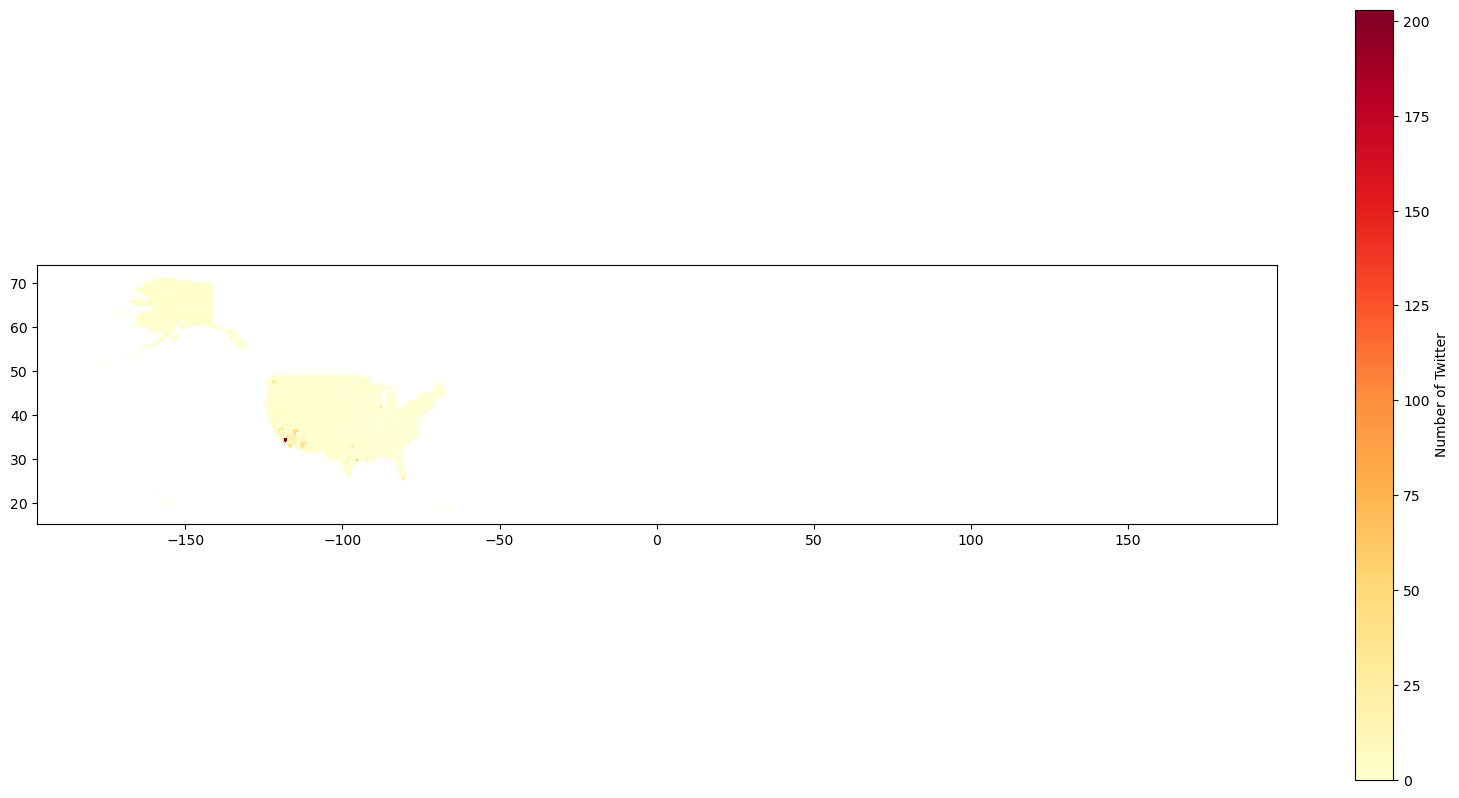

In [27]:
## Creating Choropleth Map with geopandas 
## First create map for with the number of Twitter
## Actual Value of the the number of Twitter
US.plot(column = 'number_of_twitter', #Assign numerical data column
                      legend = True, #Decide to show legend or not
                      figsize = [20,10],
                      cmap = 'YlOrRd',
                      legend_kwds = {'label': "Number of Twitter"}) #Name the legend

Natural Break

<Axes: >

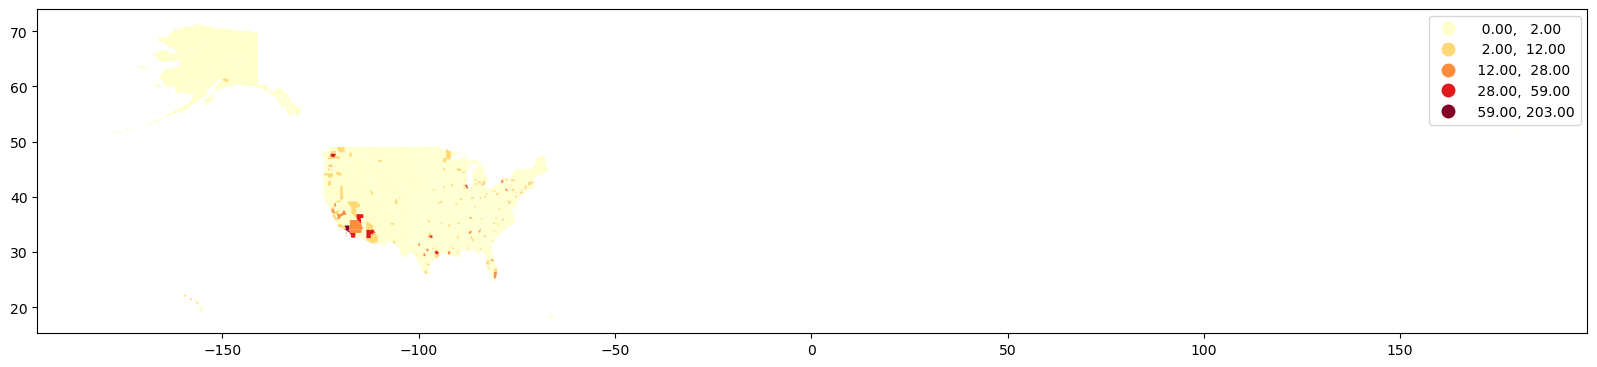

In [24]:
## Creating Choropleth Map with geopandas 
## First create map for with the number of Twitter
## Actual Value of the the number of Twitter
## Natural Break
US.plot(column = 'number_of_twitter', #Assign numerical data column
                      scheme="natural_breaks", 
                      k=5,
                      legend = True, #Decide to show legend or not
                      figsize = [20,10],
                      cmap = 'YlOrRd') #Name the legend

Quantile Map

<Axes: >

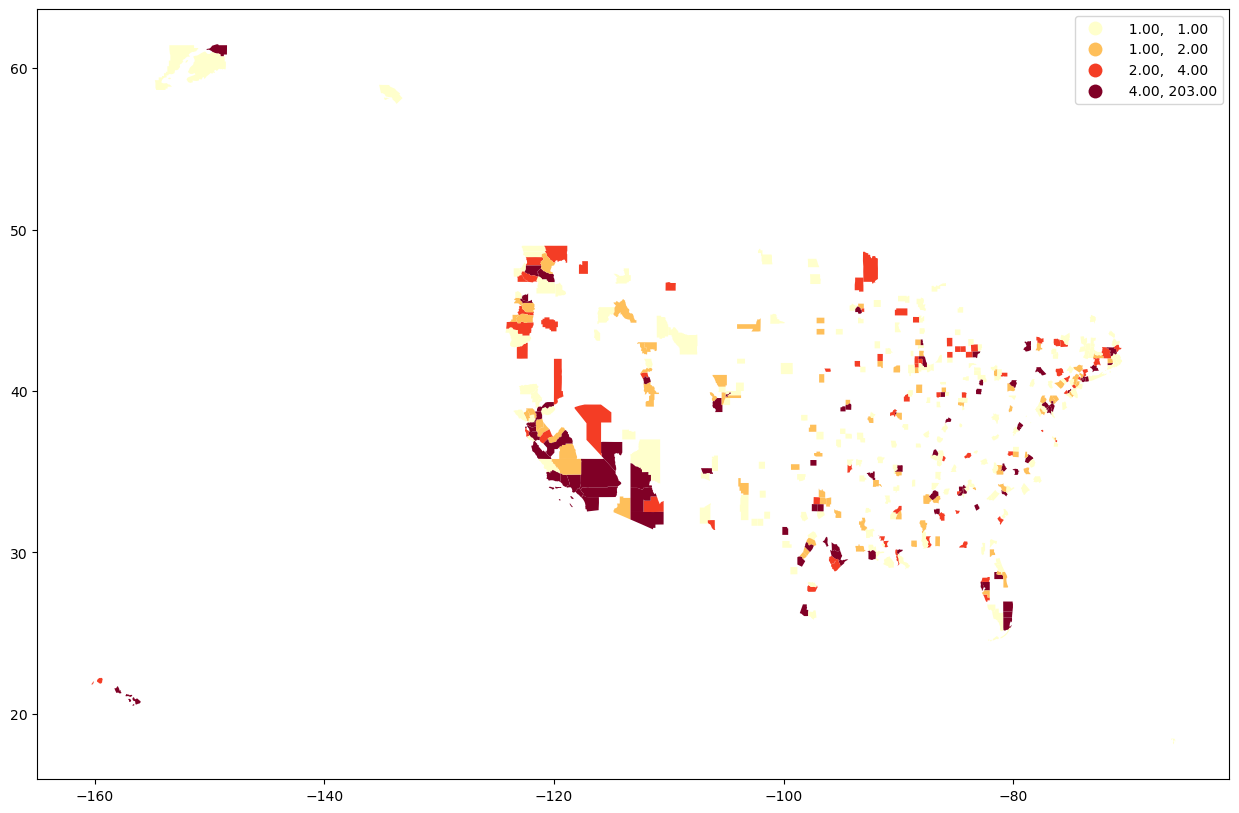

In [26]:
## Quantile Map
US.plot(column = 'number_of_twitter_for_quantile', #Assign numerical data column
                      scheme="quantiles", 
                      k=4,
                      legend = True, #Decide to show legend or not
                      figsize = [20,10],
                      cmap = 'YlOrRd') #Name the legend

### Visualization for heat exposure

<Axes: >

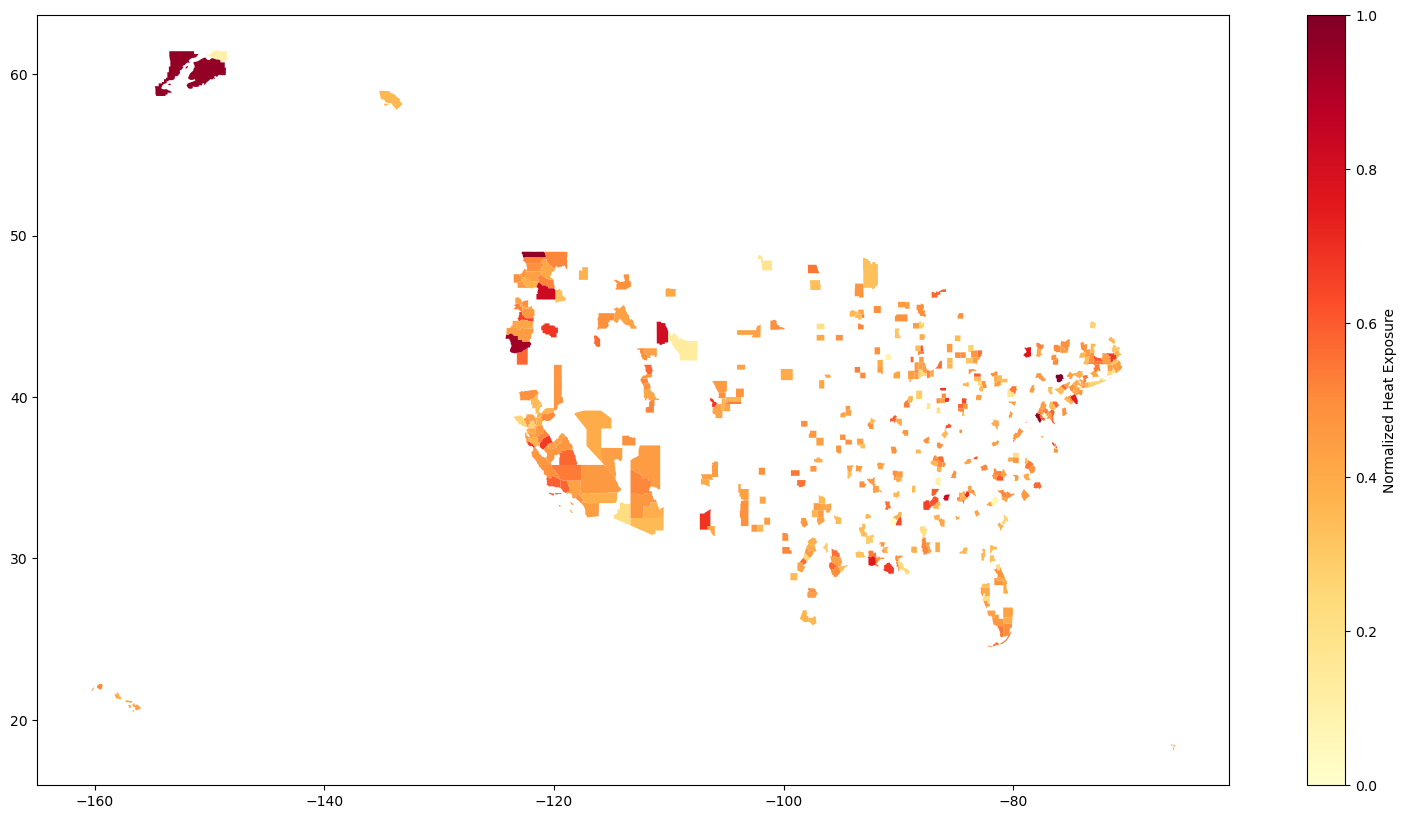

In [19]:
## Creating Choropleth Map with geopandas 
## Actual map for the Heat Exposure
US.plot(column = 'normalized_heat_exposure', #Assign numerical data column
                      legend = True, #Decide to show legend or not
                      figsize = [20,10],
                      cmap = 'YlOrRd',
                      legend_kwds = {'label': "Normalized Heat Exposure"}) #Name the legend

Natural Break

<Axes: >

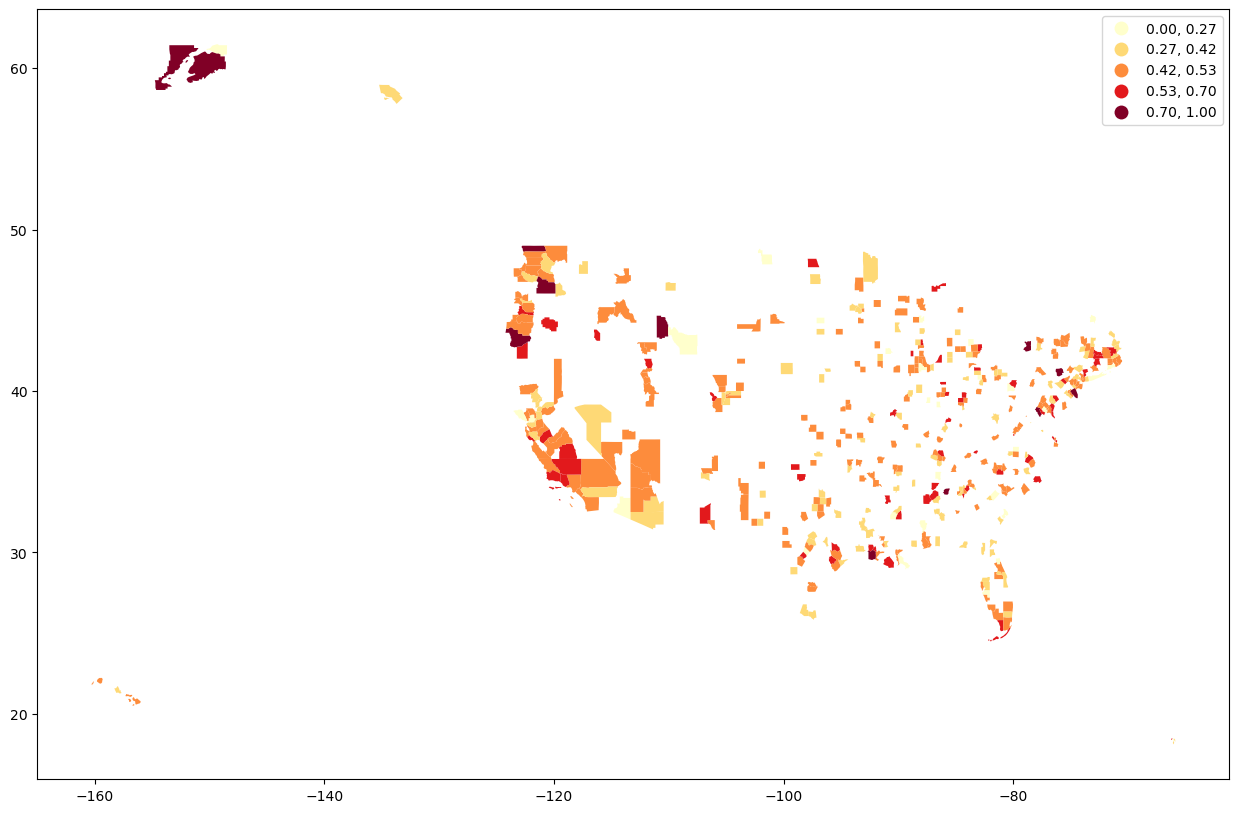

In [28]:
## Creating Choropleth Map with geopandas 
## First create map for with the number of Twitter
## Actual Value of the the number of Twitter
## Natural Break
US.plot(column = 'normalized_heat_exposure', #Assign numerical data column
                      scheme="natural_breaks", 
                      k=5,
                      legend = True, #Decide to show legend or not
                      figsize = [20,10],
                      cmap = 'YlOrRd') #Name the legend

Quantile Map

<Axes: >

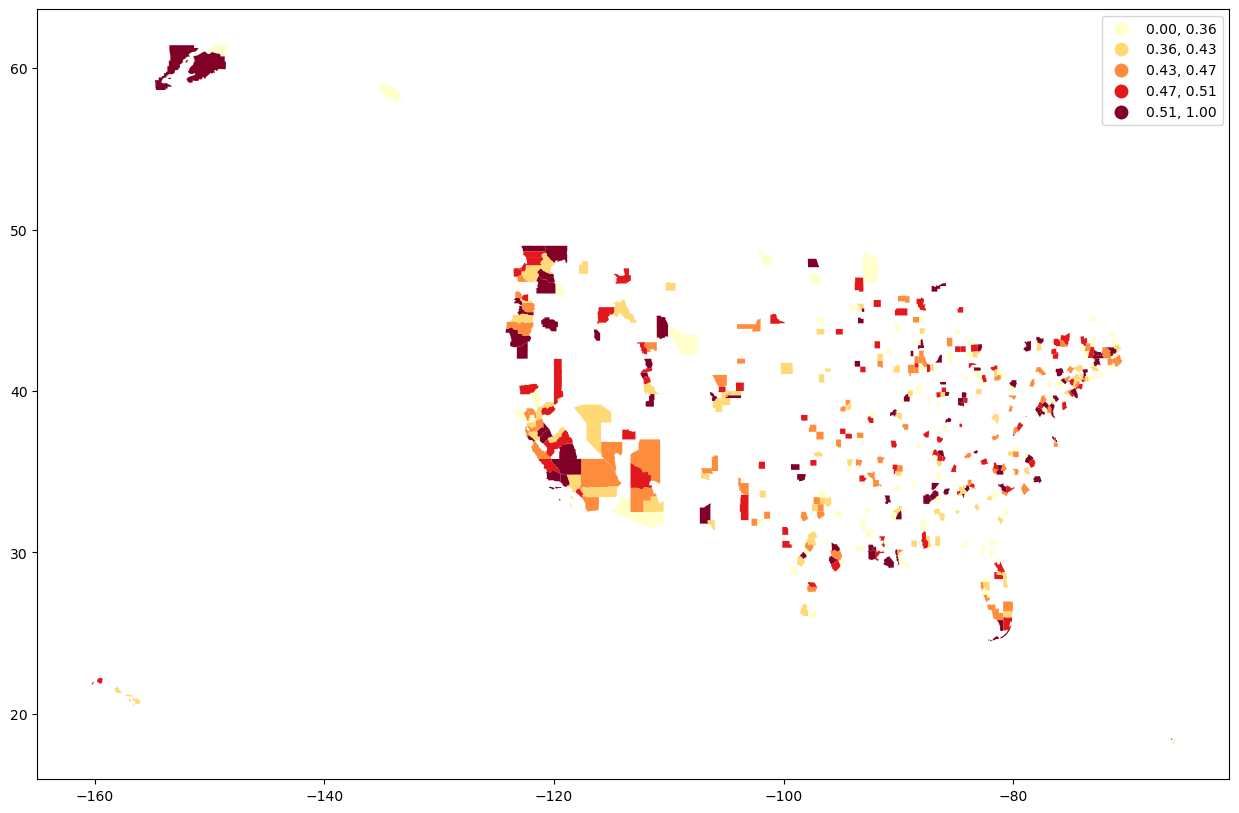

In [30]:
## Quantile Map
US.plot(column = 'normalized_heat_exposure', #Assign numerical data column
                      scheme="quantiles", 
                      k=5,
                      legend = True, #Decide to show legend or not
                      figsize = [20,10],
                      cmap = 'YlOrRd') #Name the legend

Export File

In [21]:
### write the dataframe out as geojson
with open('./national_heat_exposure.json', 'w') as f:
        f.write(US.to_json())

## End of Notbeook